# Day 3: Kernel Methods for Financial Pattern Recognition

## 🎯 Learning Objectives
- Deep understanding of kernel methods
- Custom kernel design for financial data
- Kernel PCA for non-linear dimensionality reduction
- Application to regime detection

---

## 📚 Theory: Kernel Methods

### The Kernel Trick
Transform data to a higher-dimensional space where linear methods work:
$$K(x_i, x_j) = \langle\phi(x_i), \phi(x_j)\rangle$$

### Mercer's Theorem
A function $K(x, y)$ is a valid kernel if and only if the Gram matrix is positive semi-definite.

### Popular Kernels in Finance

| Kernel | Formula | Use Case |
|--------|---------|----------|
| Linear | $x^Ty$ | Factor models |
| RBF | $exp(-\gamma\|x-y\|^2)$ | Non-linear patterns |
| Polynomial | $(\gamma x^Ty + r)^d$ | Interaction effects |
| Sigmoid | $tanh(\gamma x^Ty + r)$ | Neural network-like |

### Kernel PCA
Non-linear extension of PCA using kernels:
1. Compute kernel matrix $K$
2. Center the kernel matrix
3. Perform eigendecomposition

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
from sklearn.cluster import KMeans
import seaborn as sns

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252

# Download data
tickers = ['SPY', 'AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS', 'XLF', 'XLK', 'XLE', 'TLT']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data loaded: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data loaded: 1254 days, 10 assets


In [2]:
# Create market features for regime detection
features = pd.DataFrame(index=returns.index)

# Cross-sectional features
features['avg_return'] = returns.mean(axis=1)
features['avg_vol'] = returns.rolling(20).std().mean(axis=1) * np.sqrt(TRADING_DAYS)
features['correlation'] = returns.rolling(60).corr().groupby(level=0).apply(
    lambda x: x.values[np.triu_indices(len(tickers), k=1)].mean()
)
features['dispersion'] = returns.std(axis=1)
features['momentum'] = returns.rolling(20).sum().mean(axis=1)

features = features.dropna()
print(f"\n📊 Created {len(features.columns)} market regime features")


📊 Created 5 market regime features


In [3]:
# Compare Linear PCA vs Kernel PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Linear PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Kernel PCA with different kernels
kernels_kpca = {
    'RBF': KernelPCA(n_components=2, kernel='rbf', gamma=0.1),
    'Polynomial': KernelPCA(n_components=2, kernel='poly', degree=3),
    'Sigmoid': KernelPCA(n_components=2, kernel='sigmoid')
}

X_kpca = {}
for name, kpca in kernels_kpca.items():
    X_kpca[name] = kpca.fit_transform(X_scaled)

print(f"Linear PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

Linear PCA explained variance: 59.71%


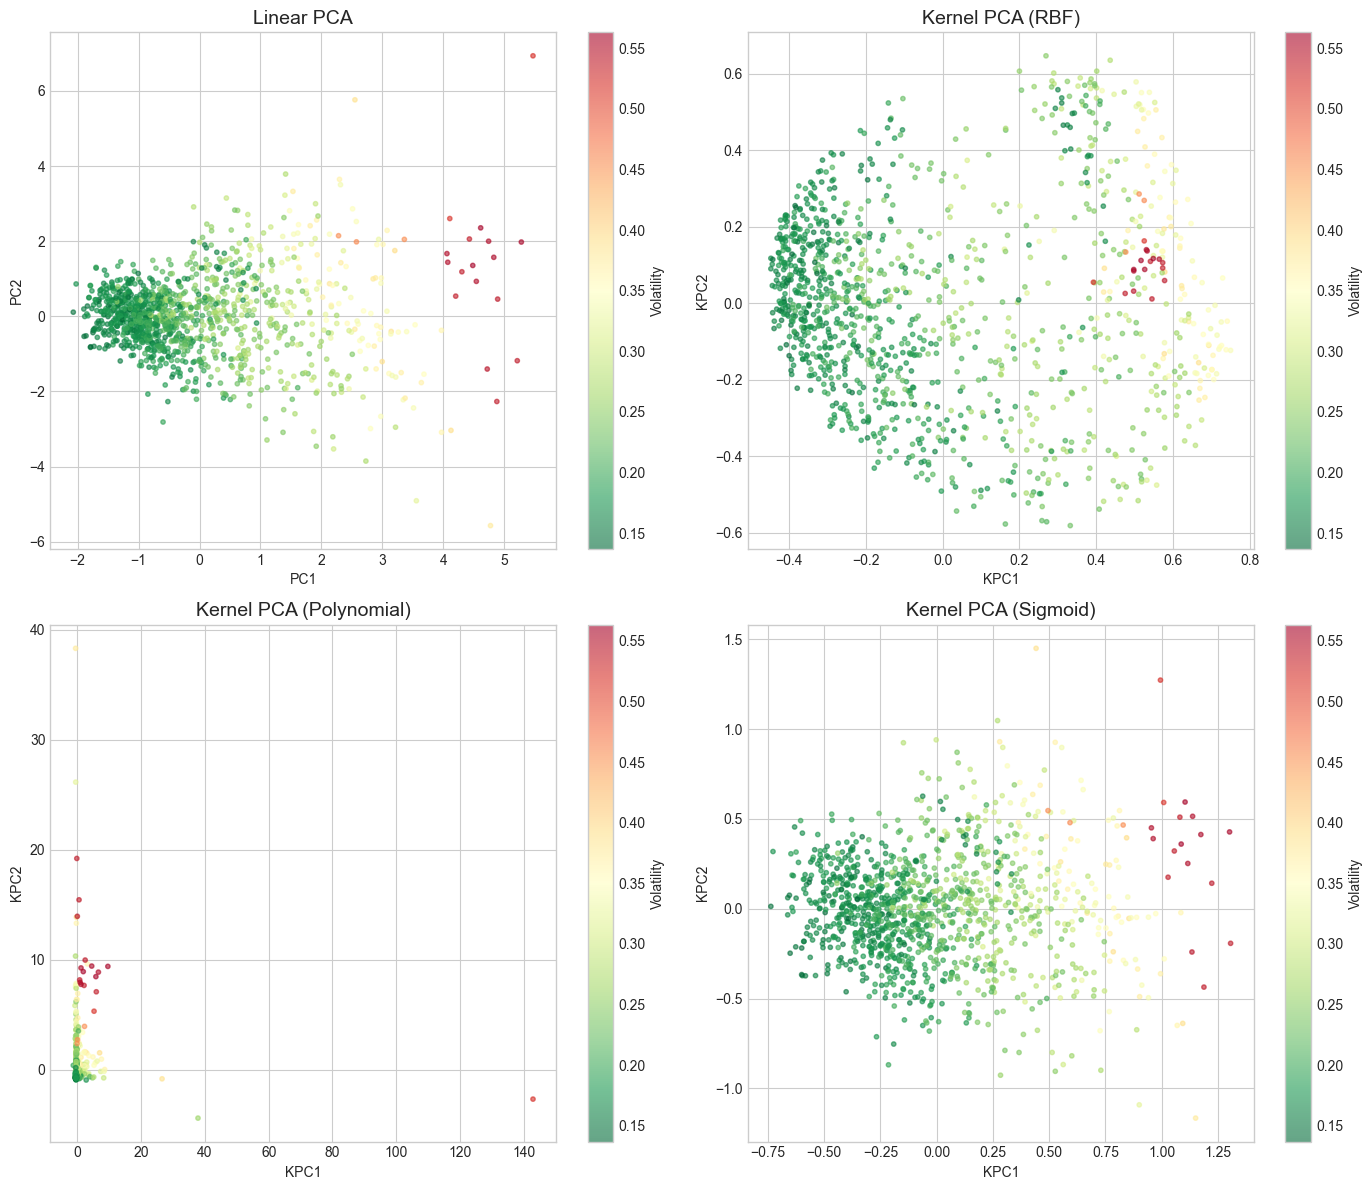

In [4]:
# Visualize PCA vs Kernel PCA
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Color by volatility (high vol = crisis periods)
colors = features['avg_vol'].values

# Linear PCA
sc = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='RdYlGn_r', alpha=0.6, s=10)
axes[0, 0].set_title('Linear PCA', fontsize=14)
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
plt.colorbar(sc, ax=axes[0, 0], label='Volatility')

# RBF Kernel PCA
sc = axes[0, 1].scatter(X_kpca['RBF'][:, 0], X_kpca['RBF'][:, 1], c=colors, cmap='RdYlGn_r', alpha=0.6, s=10)
axes[0, 1].set_title('Kernel PCA (RBF)', fontsize=14)
axes[0, 1].set_xlabel('KPC1')
axes[0, 1].set_ylabel('KPC2')
plt.colorbar(sc, ax=axes[0, 1], label='Volatility')

# Polynomial Kernel PCA
sc = axes[1, 0].scatter(X_kpca['Polynomial'][:, 0], X_kpca['Polynomial'][:, 1], c=colors, cmap='RdYlGn_r', alpha=0.6, s=10)
axes[1, 0].set_title('Kernel PCA (Polynomial)', fontsize=14)
axes[1, 0].set_xlabel('KPC1')
axes[1, 0].set_ylabel('KPC2')
plt.colorbar(sc, ax=axes[1, 0], label='Volatility')

# Sigmoid Kernel PCA
sc = axes[1, 1].scatter(X_kpca['Sigmoid'][:, 0], X_kpca['Sigmoid'][:, 1], c=colors, cmap='RdYlGn_r', alpha=0.6, s=10)
axes[1, 1].set_title('Kernel PCA (Sigmoid)', fontsize=14)
axes[1, 1].set_xlabel('KPC1')
axes[1, 1].set_ylabel('KPC2')
plt.colorbar(sc, ax=axes[1, 1], label='Volatility')

plt.tight_layout()
plt.show()

In [5]:
# Regime detection using Kernel PCA + Clustering
n_regimes = 3

# Use RBF Kernel PCA components for clustering
kmeans = KMeans(n_clusters=n_regimes, random_state=42, n_init=10)
regimes = kmeans.fit_predict(X_kpca['RBF'])

# Analyze regimes
regime_df = features.copy()
regime_df['regime'] = regimes
regime_df['spy_return'] = returns['SPY'].loc[features.index]

print("\n" + "="*70)
print("MARKET REGIME ANALYSIS (Kernel PCA + K-Means)")
print("="*70)

for r in range(n_regimes):
    mask = regime_df['regime'] == r
    regime_data = regime_df[mask]
    avg_vol = regime_data['avg_vol'].mean()
    avg_ret = regime_data['spy_return'].mean() * TRADING_DAYS
    count = mask.sum()
    pct = count / len(regime_df)
    
    regime_type = 'Crisis' if avg_vol > 0.25 else ('Low Vol' if avg_vol < 0.15 else 'Normal')
    print(f"\nRegime {r} ({regime_type}):")
    print(f"  Days: {count} ({pct:.1%})")
    print(f"  Avg Vol: {avg_vol:.1%}")
    print(f"  Ann. Return: {avg_ret:.1%}")


MARKET REGIME ANALYSIS (Kernel PCA + K-Means)

Regime 0 (Crisis):
  Days: 217 (18.2%)
  Avg Vol: 30.3%
  Ann. Return: 123.5%

Regime 1 (Normal):
  Days: 710 (59.4%)
  Avg Vol: 19.0%
  Ann. Return: 47.0%

Regime 2 (Crisis):
  Days: 268 (22.4%)
  Avg Vol: 25.2%
  Ann. Return: -163.1%


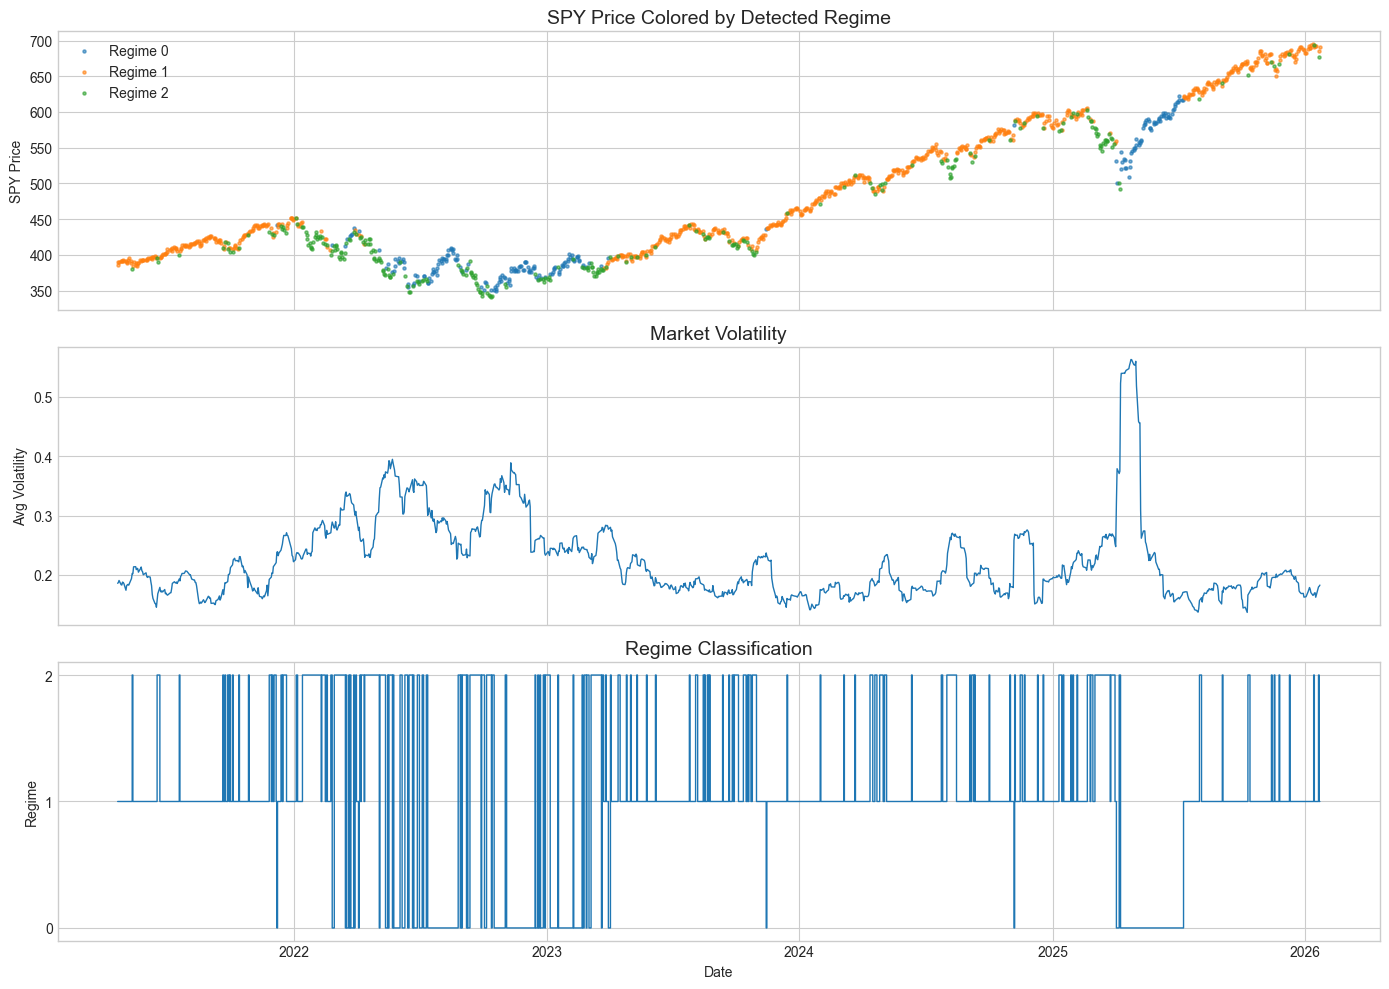

In [6]:
# Visualize regimes over time
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# SPY price with regime coloring
spy_aligned = prices['SPY'].loc[features.index]
for r in range(n_regimes):
    mask = regime_df['regime'] == r
    axes[0].scatter(spy_aligned.index[mask], spy_aligned.values[mask], 
                   label=f'Regime {r}', alpha=0.6, s=5)
axes[0].set_ylabel('SPY Price')
axes[0].set_title('SPY Price Colored by Detected Regime', fontsize=14)
axes[0].legend()

# Volatility
axes[1].plot(features.index, features['avg_vol'], linewidth=1)
axes[1].set_ylabel('Avg Volatility')
axes[1].set_title('Market Volatility', fontsize=14)

# Regime indicator
axes[2].plot(features.index, regime_df['regime'], linewidth=1, drawstyle='steps-post')
axes[2].set_ylabel('Regime')
axes[2].set_xlabel('Date')
axes[2].set_title('Regime Classification', fontsize=14)
axes[2].set_yticks(range(n_regimes))

plt.tight_layout()
plt.show()

In [7]:
# Regime-based trading strategy
strategy = regime_df.copy()

# Strategy: Full long in low-vol, half in normal, cash in crisis
regime_weights = {0: 1.0, 1: 0.5, 2: 0.0}  # Adjust based on regime characteristics

# Determine which regime is which
regime_vols = strategy.groupby('regime')['avg_vol'].mean()
low_vol_regime = regime_vols.idxmin()
high_vol_regime = regime_vols.idxmax()
normal_regime = [r for r in range(n_regimes) if r not in [low_vol_regime, high_vol_regime]][0]

# Assign weights
weight_map = {low_vol_regime: 1.5, normal_regime: 1.0, high_vol_regime: 0.3}
strategy['weight'] = strategy['regime'].map(weight_map)
strategy['strategy_return'] = strategy['weight'].shift(1) * strategy['spy_return']

# Calculate cumulative
strategy['spy_cumulative'] = (1 + strategy['spy_return']).cumprod()
strategy['strategy_cumulative'] = (1 + strategy['strategy_return']).cumprod()

print("\n" + "="*60)
print("REGIME-BASED STRATEGY PERFORMANCE")
print("="*60)
spy_ret = (strategy['spy_cumulative'].iloc[-1] - 1)
strat_ret = (strategy['strategy_cumulative'].iloc[-1] - 1)
print(f"Buy & Hold Return: {spy_ret:.2%}")
print(f"Regime Strategy Return: {strat_ret:.2%}")


REGIME-BASED STRATEGY PERFORMANCE
Buy & Hold Return: 78.91%
Regime Strategy Return: 93.25%


In [8]:
# Current regime prediction
latest_features = X_scaled[-1:]
latest_kpca = kernels_kpca['RBF'].transform(latest_features)
current_regime = kmeans.predict(latest_kpca)[0]

regime_labels = {low_vol_regime: 'Low Volatility (Bullish)', 
                 normal_regime: 'Normal', 
                 high_vol_regime: 'High Volatility (Risk-Off)'}

print("\n" + "="*60)
print("📊 CURRENT MARKET REGIME")
print("="*60)
print(f"\nDate: {features.index[-1].strftime('%Y-%m-%d')}")
print(f"Detected Regime: {current_regime} - {regime_labels.get(current_regime, 'Unknown')}")
print(f"Recommended Position: {weight_map[current_regime]:.0%} of capital")
print(f"Current Market Volatility: {features['avg_vol'].iloc[-1]:.1%}")


📊 CURRENT MARKET REGIME

Date: 2026-01-22
Detected Regime: 1 - Low Volatility (Bullish)
Recommended Position: 150% of capital
Current Market Volatility: 18.3%


## 🏢 Company Applications

| Firm | Kernel Method Use |
|------|------------------|
| Bridgewater | Regime detection with non-linear features |
| Man AHL | Kernel-based signal extraction |
| Two Sigma | Non-linear factor decomposition |

### Key Interview Points
1. **Why kernels?** - Capture non-linear relationships without explicit feature engineering
2. **Kernel choice?** - RBF for general non-linearity, Polynomial for interaction effects
3. **Computational cost?** - O(n²) for kernel matrix, use approximations for large data

---
## 📅 Tomorrow: Regime Similarity Trading